# Предисловие
У людей бывают разные хобби, порой даже странные. Вот например мой отец записывает погоду с 1998 года. Данных накопилось довольно много, поэтому я решил, что с ними можно что-то сделать.

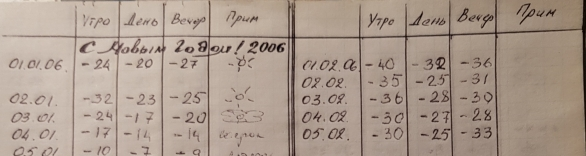

За какие-то пару недель мартышкиного труда я перенес все значения с 1998 по 2020 год в экселевскую таблицу. Дальше в силу вступает python и соответствующие библиотеки анализа данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime
sns.set()

# Анализ данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = r'/content/drive/MyDrive/Colab Notebooks/weater/table.csv'
data = pd.read_csv(path, sep=';')

In [4]:
data.head()

,date,morning,day,evening,Unnamed: 4
0,08.01.1998,-22.0,NaN,-29.0,NaN
1,09.01.1998,-36.0,NaN,-34.0,NaN
2,10.01.1998,-38.0,NaN,-37.0,NaN
3,12.01.1998,-41.5,-35.0,-39.0,NaN
4,13.01.1998,-41.5,-35.0,-38.0,NaN


В колонку Unnamed: 4 я начал вписывать пометки когда устанавливается лед на реке, но этих данных слишком мало для какой-либо оценки, так что ее использовать не буду.

In [5]:
# change format of data
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
# delete last column
data.drop(columns='Unnamed: 4', inplace=True)

In [6]:
# make index as datetime index
data.index = data['date']
data.drop(columns='date', inplace=True)

In [7]:
data.head()

,morning,day,evening
date,,,
1998-01-08,-22.0,NaN,-29.0
1998-01-09,-36.0,NaN,-34.0
1998-01-10,-38.0,NaN,-37.0
1998-01-12,-41.5,-35.0,-39.0
1998-01-13,-41.5,-35.0,-38.0


Показания снятые днем, утром и вечером снимали приблизительно в 7, 15 и 23 часа. Преобразуем это в датафрейм с расширенным индексом.

In [8]:
data_morning = data['morning']
data_day = data['day']
data_evening = data['evening']
data_morning.index = data_morning.index + pd.Timedelta(7, 'hour')
data_day.index = data_day.index + pd.Timedelta(15, 'hour')
data_evening.index = data_evening.index + pd.Timedelta('23:00:00')

In [9]:
tmp = pd.merge(data_morning, data_day, 'outer', left_index=True, right_index=True)
data_full = pd.merge(tmp, data_evening, 'outer', left_index=True, right_index=True)

In [10]:
data_full.head()

,morning,day,evening
date,,,
1998-01-08 07:00:00,-22.0,NaN,NaN
1998-01-08 15:00:00,NaN,NaN,NaN
1998-01-08 23:00:00,NaN,NaN,-29.0
1998-01-09 07:00:00,-36.0,NaN,NaN
1998-01-09 15:00:00,NaN,NaN,NaN


Преобразуем данные в последовательность, объединив все данные в один столбец.

In [11]:
def func(x):
    if pd.notna(x['morning']):
        return x['morning']
    elif pd.notna(x['day']):
        return x['day']
    elif pd.notna(x['evening']):
        return x['evening']
    else:
        return np.nan
        
data_full_s =  data_full.apply(func, axis=1)

In [12]:
data_full_s.head()

date
1998-01-08 07:00:00   -22.0
1998-01-08 15:00:00     NaN
1998-01-08 23:00:00   -29.0
1998-01-09 07:00:00   -36.0
1998-01-09 15:00:00     NaN
dtype: float64

In [13]:
len(data_full_s)

24699

В данных содержатся пропуски. Попытаемся приблизительно оценить их количество и местонахождение в последовательности.

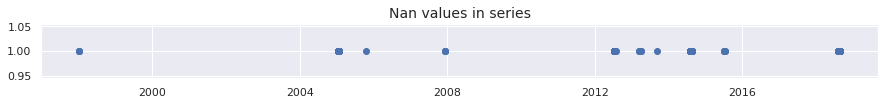

In [14]:
nan_data = data_full_s[pd.isna(data_full_s)]
fig, ax = plt.subplots(1,1, figsize=(15,1))
ax.scatter(nan_data.index, [1]*len(nan_data))
ax.set_title('Nan values in series', fontsize=14);

Такое количество пропусков позволяет работать с данными дальше

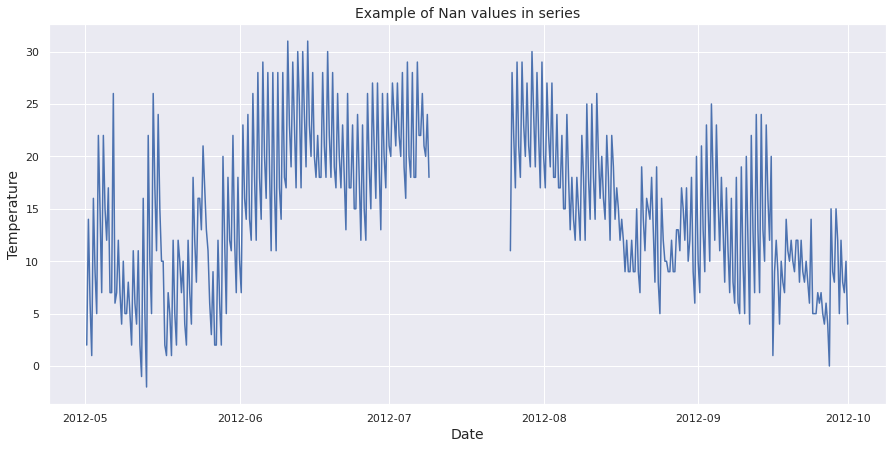

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.plot(data_full_s['2012-05':'2012-09'])

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature', fontsize=14);
ax.set_title('Example of Nan values in series', fontsize=14);

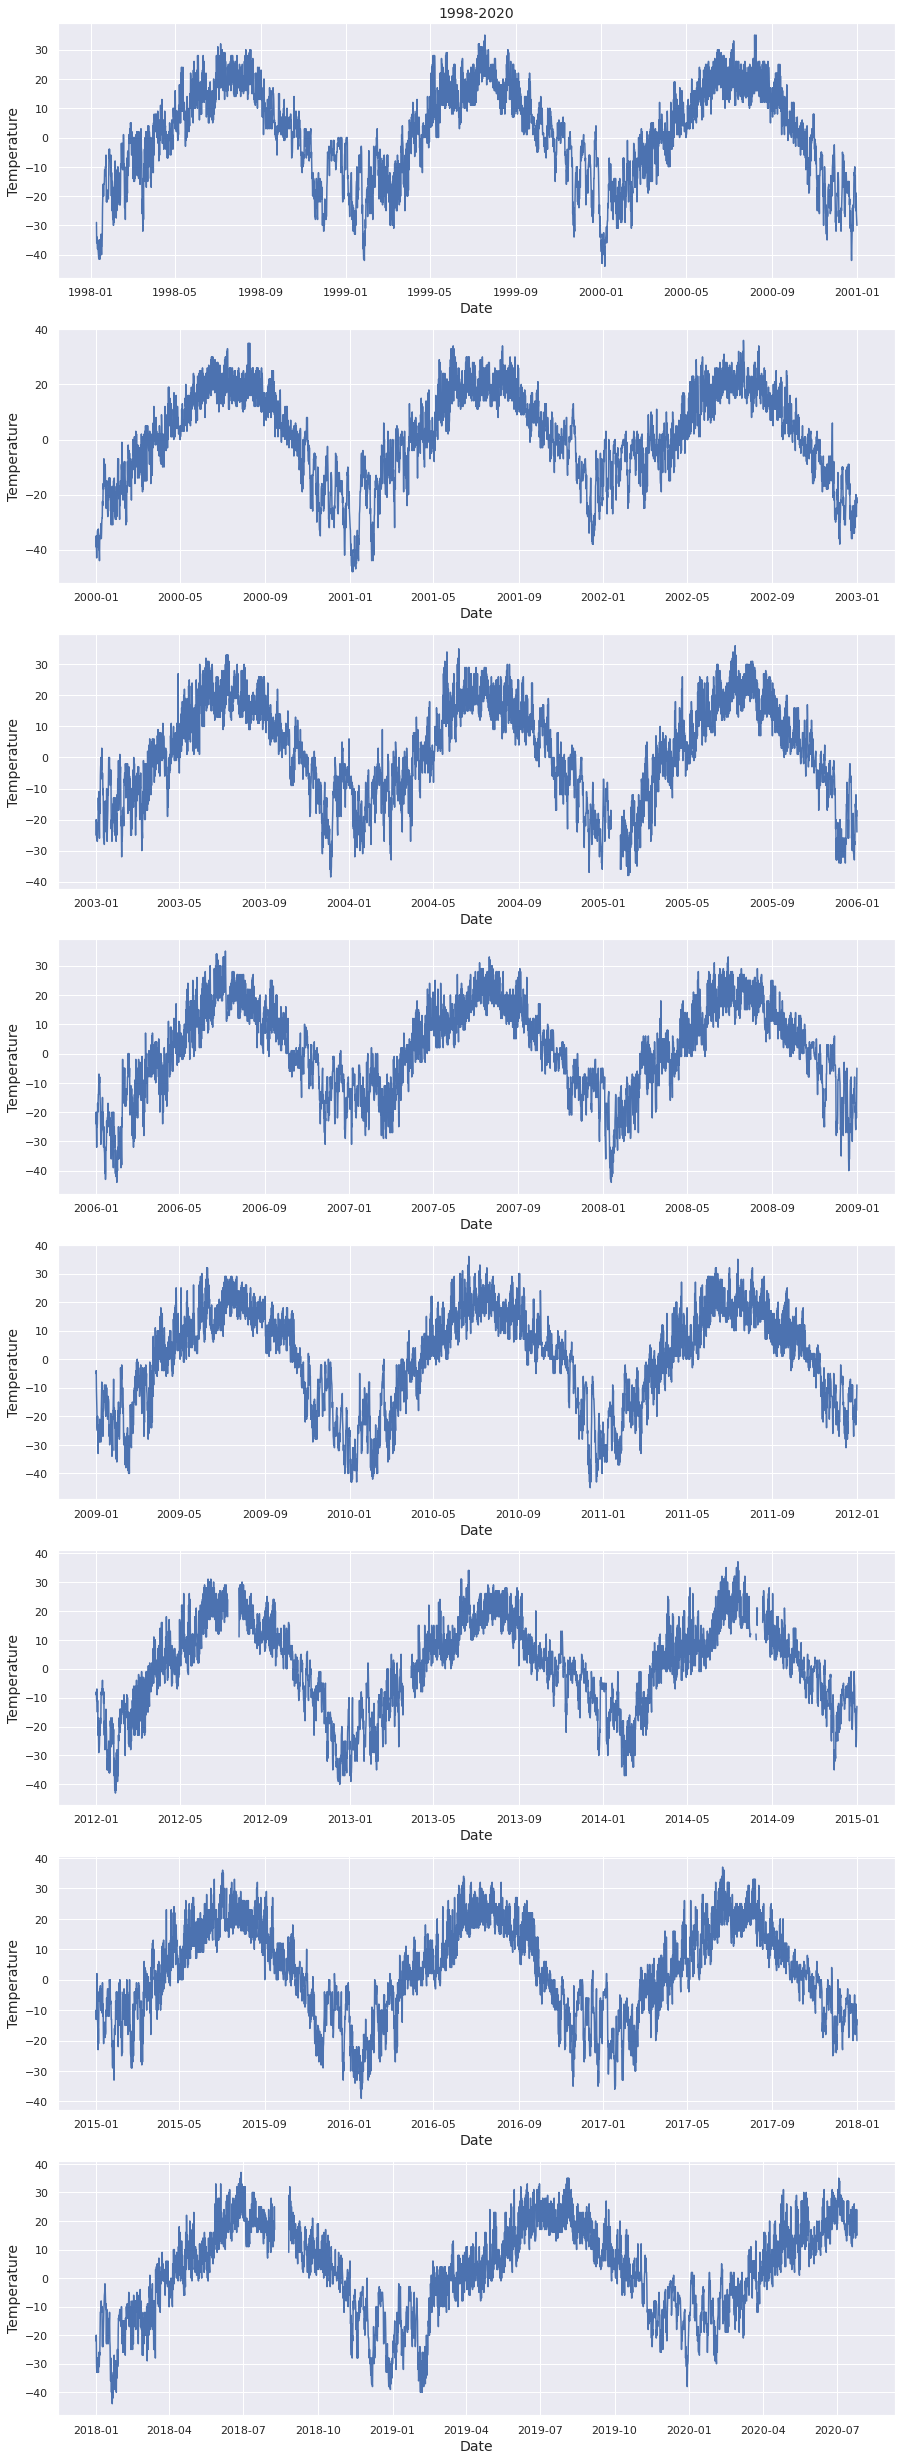

In [16]:
fig, ax = plt.subplots(8,1, figsize=(15,44))
ax[0].plot(data_full_s['1998':'2000'])
ax[1].plot(data_full_s['2000':'2002'])
ax[2].plot(data_full_s['2003':'2005'])
ax[3].plot(data_full_s['2006':'2008'])
ax[4].plot(data_full_s['2009':'2011'])
ax[5].plot(data_full_s['2012':'2014'])
ax[6].plot(data_full_s['2015':'2017'])
ax[7].plot(data_full_s['2018':'2020'])
ax[0].set_title('1998-2020', fontsize=14)
for a in ax.ravel():
    a.set_xlabel('Date', fontsize=14)
    a.set_ylabel('Temperature', fontsize=14);
    

В целом, наблюдается цикличность показателей температуры (в общем-то это и без графиков всем ясно должно быть) Уже по этим графиками можно заметить самые стабильные и нестабильные промежутки времени по температуре (зима и лето). Значительных пропусков не наблюдается.

#### Статистические показатели погоды

In [17]:
data_daymean = data_full_s.groupby(data_full_s.index.date).mean()
data_monthmean = data_full_s.groupby(data_full_s.index.month).mean()
data_yearmean = data_full_s.groupby(data_full_s.index.year).mean()

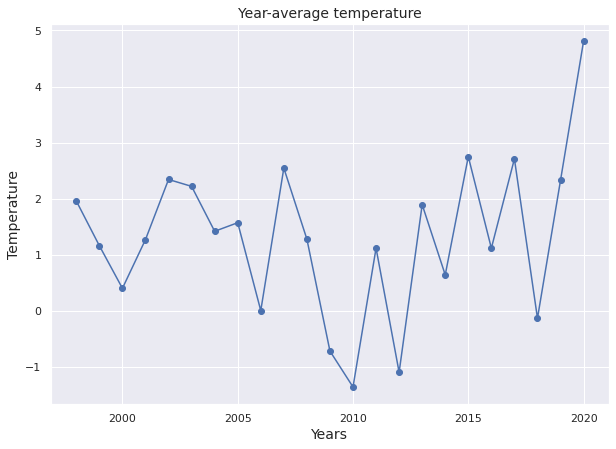

In [18]:
plt.figure(figsize=(10,7))
plt.plot(data_yearmean, marker='o')
plt.title('Year-average temperature', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Temperature', fontsize=14);

Город Зеленогорск Красноярского края, находится в низине, поэтому погода может сильно отличаться даже с поселком Октябрьский, в 10 км от города.

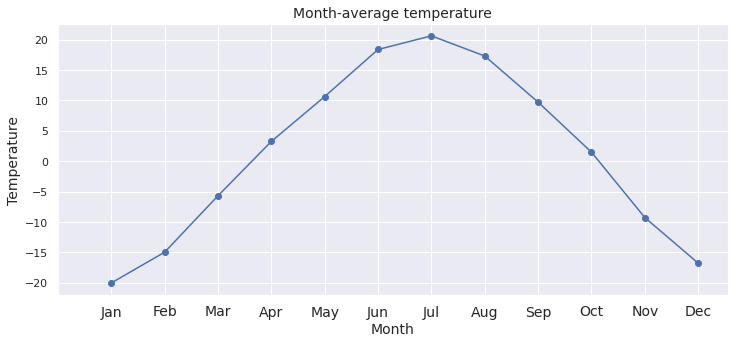

In [19]:
# months_names = ['','Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
months_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12,5))
plt.plot(data_monthmean, marker='o')
plt.xticks(range(13), labels=months_names, rotation=0, fontsize=14);
plt.title('Month-average temperature', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature', fontsize=14);

Одна из особенностей сибирского климата - жаркое лето и холодная, более продолжительная чем в центральных регионах, зима.

In [20]:
print('Средняя температура за все время измерений: {:.2f}\u00b0C'.format(data_full_s.mean()))
print()
print('Минимальная температура за все время измерений: {}\u00b0C'.format(data_full_s.min()))
print('Даты:')
for x in data_full_s[data_full_s==data_full_s.min()].index:
      print(x)
print()
print('Максимальная температура за все время измерений: {}\u00b0C'.format(data_full_s.max()))
print('Даты:')
for x in data_full_s[data_full_s==data_full_s.max()].index:
      print(x)

Средняя температура за все время измерений: 1.25°C

Минимальная температура за все время измерений: -48.0°C
Даты:
2001-01-04 07:00:00
2001-01-05 07:00:00

Максимальная температура за все время измерений: 37.0°C
Даты:
2014-07-13 15:00:00
2017-06-21 15:00:00
2018-06-28 15:00:00


Интересно что минимальная температура 5 января 2001 была зарегистрирована также и в Красноярске, но за всю историю метеонаблюдений (около 90 лет). 

In [21]:
month_std = data_full_s.groupby(data_full_s.index.month).std()

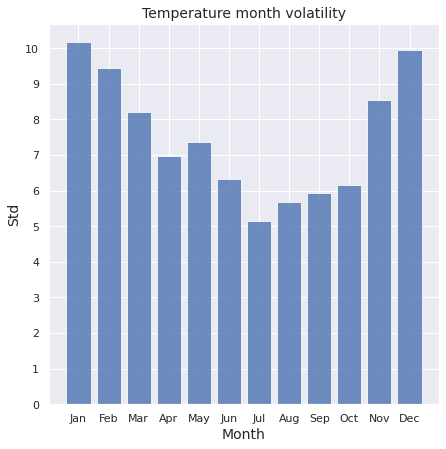

In [22]:
plt.figure(figsize=(7,7))
plt.bar(month_std.index, month_std.values, tick_label=months_names[1:], alpha=0.8)
plt.yticks(range(11))
plt.title('Temperature month volatility', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Std', fontsize=14);

Как видно по диаграмме выше погода становится менее изменчивой к лету.

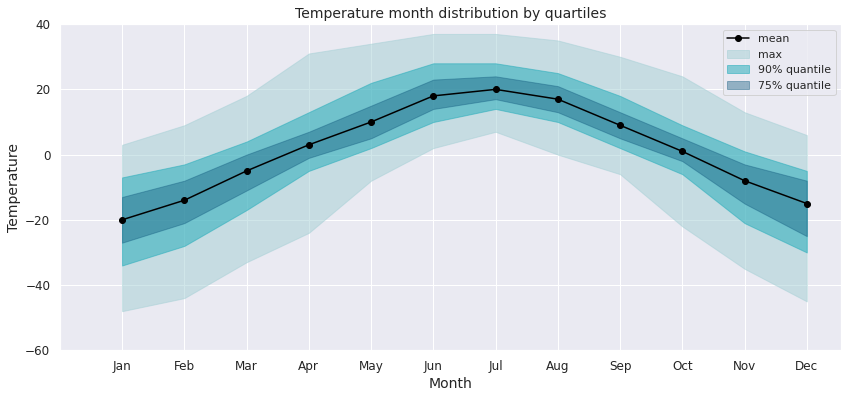

In [23]:
plt.figure(figsize=(14,6))

plt.plot(data_full_s.groupby(data_full_s.index.month).quantile(0.5), marker='o', label='mean', color='black')

plt.fill_between(range(1,13), data_full_s.groupby(data_full_s.index.month).min(),
                data_full_s.groupby(data_full_s.index.month).max(), alpha=0.5, label='max', color='#a3cfd4')

plt.fill_between(range(1,13), data_full_s.groupby(data_full_s.index.month).quantile(0.1),
                data_full_s.groupby(data_full_s.index.month).quantile(0.9), alpha=0.5, label='90% quantile', color='#1caab8')

plt.fill_between(range(1,13), data_full_s.groupby(data_full_s.index.month).quantile(0.25),
                data_full_s.groupby(data_full_s.index.month).quantile(0.75), alpha=0.4, label='75% quantile', color='#10597d')

plt.title('Temperature month distribution by quartiles', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.ylim(-60,40)
plt.yticks(fontsize=12)
plt.legend()
plt.xticks(range(13), labels=months_names, rotation=0, fontsize=12);

Оценим количество дней выше и ниже определенной температуры за каждый год измерений. Так можно точнее определить на сколько холодный или теплый был год. Такую же оценку можно провести по каждому месяцу. Для этого лучше провести интерполяцию пропущенных данных.

In [24]:
#data_daymean = data_full_s.groupby(data_full_s.index.date).mean()
data_daymean.index = pd.to_datetime(data_daymean.index)
data_interpolated_daymean = data_daymean.interpolate()

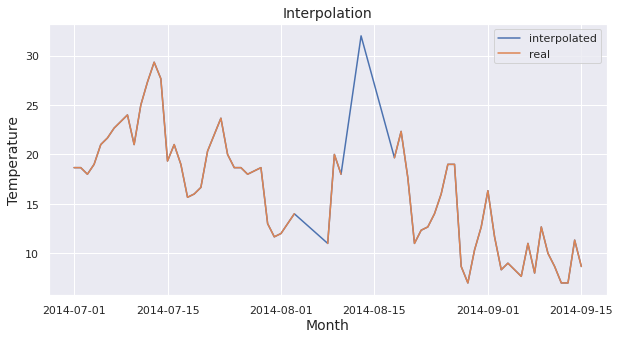

In [25]:
plt.figure(figsize=(10,5))
plt.plot(data_interpolated_daymean['2014-07':'2014-09-15'], label='interpolated')
plt.plot(data_daymean['2014-07':'2014-09-15'], label='real')
plt.legend()
plt.title('Interpolation', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature', fontsize=14);

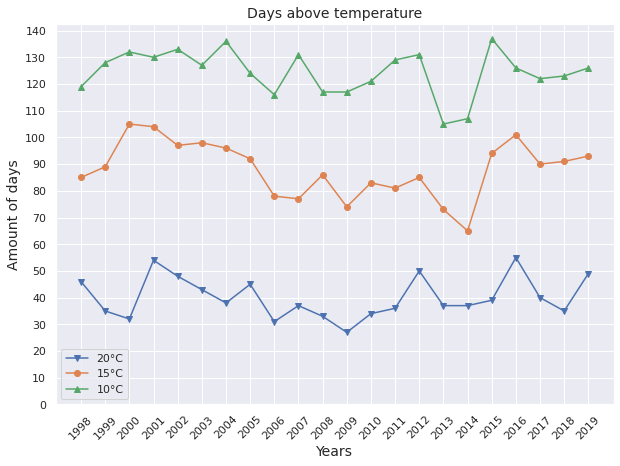

In [26]:
data_summer_15 = data_interpolated_daymean[data_interpolated_daymean >= 15]
data_summer_15.index = pd.to_datetime(data_summer_15.index)

data_summer_10 = data_interpolated_daymean[data_interpolated_daymean >= 10]
data_summer_10.index = pd.to_datetime(data_summer_10.index)

data_summer_20 = data_interpolated_daymean[data_interpolated_daymean >= 20]
data_summer_20.index = pd.to_datetime(data_summer_20.index)

summer_days_15 = []
summer_days_10 = []
summer_days_20 = []

for y in range(1998, 2020):
    #print('Count summer days {}: {}'.format(y, data_summer[data_summer.index.year == y].count()))
    summer_days_15.append(data_summer_15[data_summer_15.index.year == y].count())
    summer_days_10.append(data_summer_10[data_summer_10.index.year == y].count())
    summer_days_20.append(data_summer_20[data_summer_20.index.year == y].count())

fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(range(1998, 2020), summer_days_20, marker='v', label='20\u00b0C')
ax.plot(range(1998, 2020), summer_days_15, marker='o', label='15\u00b0C')
ax.plot(range(1998, 2020), summer_days_10, marker='^', label='10\u00b0C')
ax.set_xticks(range(1998, 2020))
ax.set_yticks(range(0, 150, 10))
ax.set_xticklabels(range(1998, 2020), rotation=45)
ax.set_title('Days above temperature', fontsize=14)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Amount of days', fontsize=14)
ax.legend();

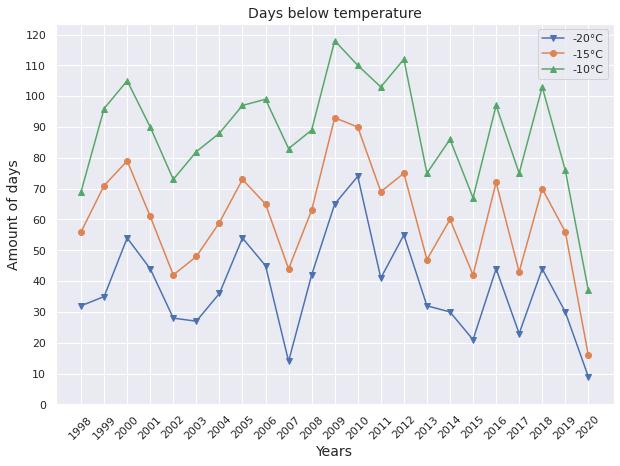

In [27]:
data_winter_15 = data_interpolated_daymean[data_interpolated_daymean <= -15]
data_winter_15.index = pd.to_datetime(data_winter_15.index)

data_winter_10 = data_interpolated_daymean[data_interpolated_daymean <= -10]
data_winter_10.index = pd.to_datetime(data_winter_10.index)

data_winter_20 = data_interpolated_daymean[data_interpolated_daymean <= -20]
data_winter_20.index = pd.to_datetime(data_winter_20.index)

winter_days_15 = []
winter_days_10 = []
winter_days_20 = []

for y in range(1998, 2021):
    #print('Count summer days {}: {}'.format(y, data_summer[data_summer.index.year == y].count()))
    winter_days_15.append(data_winter_15[data_winter_15.index.year == y].count())
    winter_days_10.append(data_winter_10[data_winter_10.index.year == y].count())
    winter_days_20.append(data_winter_20[data_winter_20.index.year == y].count())

fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(range(1998, 2021), winter_days_20, marker='v', label='-20\u00b0C')
ax.plot(range(1998, 2021), winter_days_15, marker='o', label='-15\u00b0C')
ax.plot(range(1998, 2021), winter_days_10, marker='^', label='-10\u00b0C')
ax.set_xticks(range(1998, 2021))
ax.set_yticks(range(0, 130, 10))
ax.set_xticklabels(range(1998, 2021), rotation=45)
ax.set_title('Days below temperature', fontsize=14)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Amount of days', fontsize=14)
ax.legend();

## Time series prediction using reccurent networks
#### Сначала выполним подготовку данных

In [28]:
window_size = 13 # размеры окна
predict_size = 1 # размер предсказываемого окна
windows = []
predict_size_window = window_size - predict_size
values = data_full_s.values[:(len(data_full_s.values)//window_size)*window_size - len(data_full_s.values)]

for i in range(0, window_size): # делаем множество окон с shape=(batch, window_size), смещенных относительно друг друга на 1
    windows.append(values[i:i-window_size].reshape(-1,window_size))

# Например исходные данные
# [[0,1,2,3,4,5,6,7,8,9],
#  [10,11,12,13,14,15,16,17,18,19],
#  [20,21,22,23,24,25,26,27,28,29]...]
#
# Трансформируются в
# [[[1,2,3,4,5,6,7,8,9,10],
#  [11,12,13,14,15,16,17,18,19,20],
#  [21,22,23,24,25,26,27,28,29,30]...]
#
# [[2,3,4,5,6,7,8,9,10,11],
#  [12,13,14,15,16,17,18,19,20,21],
#  [22,23,24,25,26,27,28,29,30,31]...]
#
#                ...                 ]
# при этом последняя последовательность последней оси (последняя строка)
# отбрасывается, так как ее размер уменьшается на размер смещения

In [29]:
windows_stacked = np.vstack(windows) 
# удалим строки в которых есть пропуски
windows_stacked_cleaned = windows_stacked[~np.isnan(windows_stacked).any(axis=1)] 

In [30]:
windows_stacked.shape

(24674, 13)

In [31]:
windows_stacked_cleaned.shape

(24320, 13)

In [32]:
# Разделить на фичи и метки 
X, y = windows_stacked_cleaned[:,:predict_size_window], windows_stacked_cleaned[:,predict_size_window:] 

In [33]:
X.shape, y.shape

((24320, 12), (24320, 1))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Нейросети работают лучше, на масштабированных данных
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [35]:
# добавить ось, для реккурентного слоя
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [36]:
X_train_scaled.shape, y_train_scaled.shape

((19456, 12, 1), (19456, 1))

In [37]:
# Maybe use lower init-ranges.
init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)

model = keras.models.Sequential([
    keras.layers.GRU(512, return_sequences=True),
    keras.layers.GRU(512, return_sequences=False),
    keras.layers.Dense(predict_size, activation='linear', kernel_initializer=init)
])

model.compile(loss='MSE', optimizer='Adam', metrics=['MAE'])

In [38]:
model.fit(X_train_scaled,
          y_train_scaled,          
          epochs=4)

Epoch 1/4
608/608 [==============================] - 15s 19ms/step - loss: 0.0121 - MAE: 0.0718
Epoch 2/4
608/608 [==============================] - 11s 19ms/step - loss: 0.0032 - MAE: 0.0442
Epoch 3/4
608/608 [==============================] - 12s 20ms/step - loss: 0.0019 - MAE: 0.0335
Epoch 4/4
608/608 [==============================] - 12s 19ms/step - loss: 0.0019 - MAE: 0.0339


In [39]:
model.evaluate(X_test_scaled, y_test_scaled)

152/152 [==============================] - 1s 6ms/step - loss: 0.0016 - MAE: 0.0308


[0.0016264371806755662, 0.03079211711883545]

In [40]:
predict = y_scaler.inverse_transform(model.predict(X_test_scaled))
y_test_inv = y_scaler.inverse_transform(y_test_scaled)
X_test_inv = x_scaler.inverse_transform(np.squeeze(X_test_scaled, axis=-1))

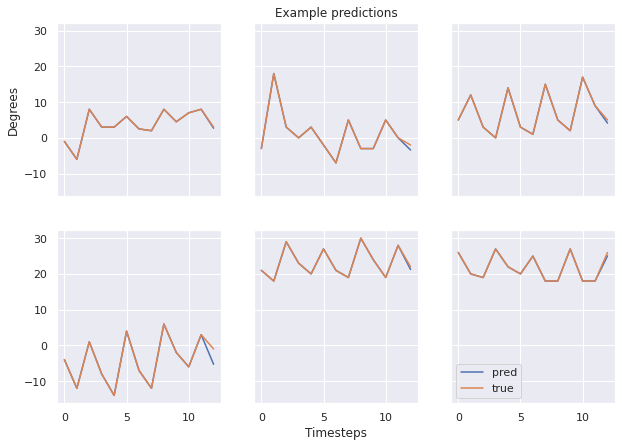

In [41]:
nums = np.random.randint(0, len(X_test_inv), size=6)
fig, axs = plt.subplots(2,3, sharey=True, sharex=True,figsize=(10,7))
ax = axs.ravel()
for i, num in enumerate(nums):
  sample_test = X_test_inv[num]
  sample_test = np.hstack((sample_test, predict[num]))
  sample_true = np.hstack((X_test_inv[num], y_test_inv[num]))
  ax[i].plot(sample_test, label='pred')
  ax[i].plot(sample_true, label='true')
ax[4].set_xlabel('Timesteps')
ax[0].set_ylabel('Degrees')
ax[1].set_title('Example predictions')
ax[-1].legend();

Сделаем оценку модели следующим образом. Найдем среднее значение абсолютной ошибки по каждому предсказанию (по трем измерением сразу) из тестового набора. Затем оценим количество ошибок по градусам. То есть сколько было предсказаний со средней ошибкой меньше одного градуса, меньше двух и так далее.

In [42]:
# MAE metrics
mean_val = np.mean(np.abs(y_test - predict),axis=1)
# Если мы хотим оценивать не среднее по всему предсказанию, а каждое измерение,
# то нужно использовать это (ниже)
#mean_val = np.abs(y_test_inv - predict)

In [43]:
# Найдем количество измерений 
diffs = [np.sum(mean_val<=1), np.sum((mean_val<=2) & (mean_val>1)),
         np.sum((mean_val<=3) & (mean_val>2)), np.sum((mean_val<=4) & (mean_val>3)),
         np.sum((mean_val<=5) & (mean_val>4)), np.sum((mean_val<=6) & (mean_val>5)),
         np.sum((mean_val<=7) & (mean_val>6)), np.sum((mean_val<=8) & (mean_val>7)),
         np.sum((mean_val<=9) & (mean_val>8)), np.sum((mean_val<=10) & (mean_val>9)),
         np.sum((mean_val<=11) & (mean_val>10)), np.sum((mean_val<=12) & (mean_val>11)),
         np.sum((mean_val<=13) & (mean_val>12)), np.sum((mean_val<=14) & (mean_val>13)),
         np.sum((mean_val<=15) & (mean_val>14)), np.sum((mean_val<=16) & (mean_val>15)),
         np.sum((mean_val<=17) & (mean_val>16))
        ]

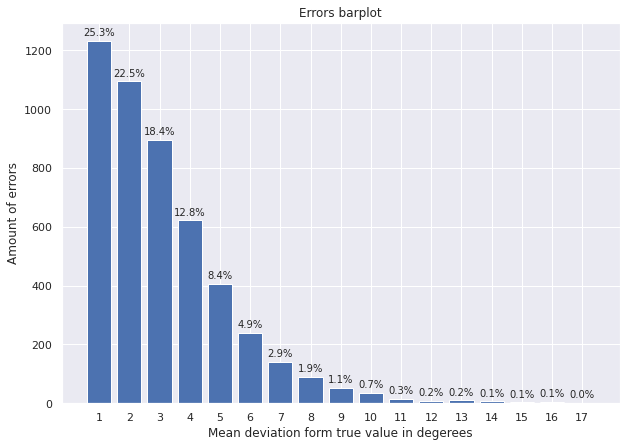

In [44]:
# Поставить цифры на верх бара
def autolabel(rects, d):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        p = height/np.sum(d)
        ax.annotate('{:.1%}'.format(p),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
fig, ax = plt.subplots(figsize=(10,7))

rect = ax.bar(range(1, len(diffs)+1), diffs, align='center')
autolabel(rect, diffs)
ax.set_xticks(range(1, len(diffs)+1))
ax.set_title('Errors barplot')
ax.set_xlabel('Mean deviation form true value in degerees')
ax.set_ylabel('Amount of errors');

In [45]:
print('Меньше трех градусов {:.1%} значений'.format(np.sum(diffs[:3])/np.sum(diffs)))

Меньше трех градусов 66.3% значений


Результат не особо точный. В наше время профессиональная метеослужба делает краткосрочные прогнозы с точностью более 95%. Сравним результат с наивной моделью, в которой предсказания такие же как и предыдущие измерения 

## Наивная модель

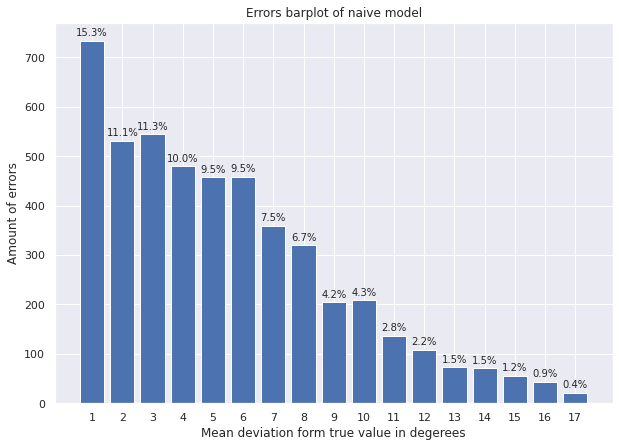

In [46]:
mean_val_naive = np.mean(np.abs(y_test - X_test[:,-predict_size:]),axis=1)
#mean_val_naive = np.abs(y_test - X_test[:,-predict_size:])
diffs_naive = [np.sum(mean_val_naive<=1), np.sum((mean_val_naive<=2) & (mean_val_naive>1)),
         np.sum((mean_val_naive<=3) & (mean_val_naive>2)), np.sum((mean_val_naive<=4) & (mean_val_naive>3)),
         np.sum((mean_val_naive<=5) & (mean_val_naive>4)), np.sum((mean_val_naive<=6) & (mean_val_naive>5)),
         np.sum((mean_val_naive<=7) & (mean_val_naive>6)), np.sum((mean_val_naive<=8) & (mean_val_naive>7)),
         np.sum((mean_val_naive<=9) & (mean_val_naive>8)), np.sum((mean_val_naive<=10) & (mean_val_naive>9)),
         np.sum((mean_val_naive<=11) & (mean_val_naive>10)), np.sum((mean_val_naive<=12) & (mean_val_naive>11)),
         np.sum((mean_val_naive<=13) & (mean_val_naive>12)), np.sum((mean_val_naive<=14) & (mean_val_naive>13)),
         np.sum((mean_val_naive<=15) & (mean_val_naive>14)), np.sum((mean_val_naive<=16) & (mean_val_naive>15)),
         np.sum((mean_val_naive<=17) & (mean_val_naive>16))
        ]

fig, ax = plt.subplots(figsize=(10,7))

rect = ax.bar(range(1, len(diffs_naive)+1), diffs_naive, align='center')
autolabel(rect, diffs_naive)
ax.set_xticks(range(1, len(diffs_naive)+1))
ax.set_title('Errors barplot of naive model')
ax.set_xlabel('Mean deviation form true value in degerees')
ax.set_ylabel('Amount of errors');

In [47]:
print('Меньше трех градусов {:.1%} значений'.format(np.sum(diffs_naive[:3])/np.sum(diffs_naive)))

Меньше трех градусов 37.7% значений


Наивная модель уступает реккурентной нейросети. Однако даже эта реккурентная сеть не может использоваться для реальных прогнозов. Более того, данные с метеостанций снимаются каждый час, эти станции находятся в специальном месте, чтобы показания были более точными. Мои показания были сняты с обычного бытового термометра за окном и всего 3 измерения за сутки. Такие данные имеют большую разницу между значениями, чем ежечасные, поэтому модели труднее делать верные предсказания. По этой причине наивная модель повторяющая три последних показания превосходит по точности, чем аналогичная реккурентная. Попробуем использовать SVM модель, и посмотрим на сколько хорошей она получится.

## SVM модель

In [48]:
# интерполяция данных
data_full_i = data_full_s.interpolate()

In [49]:
timestamp_s = data_full_i.index.map(datetime.datetime.timestamp).values

In [50]:
data_frame = pd.DataFrame(data_full_i, columns=['T'])

Данные погоды изменяются постепенно и циклично, но например новый месяц начинается с 1 числа, а заканчивается 30(31). Тоже самое с месяцами в году с 1 по 12 число. Синусно косинусное преобразование позволяет избавиться от резкого изменения значений. 

In [51]:
day = data_frame.index.day.values
month = data_frame.index.month.values
year = data_frame.index.year.values

data_frame['day_sin'] = np.sin(day * (2 * np.pi / 30.4167))
data_frame['day_cos'] = np.cos(day * (2 * np.pi / 30.4167))
data_frame['month_sin'] = np.sin(month * 2 * np.pi / 12)
data_frame['month_cos'] = np.cos(month * 2 * np.pi / 12)

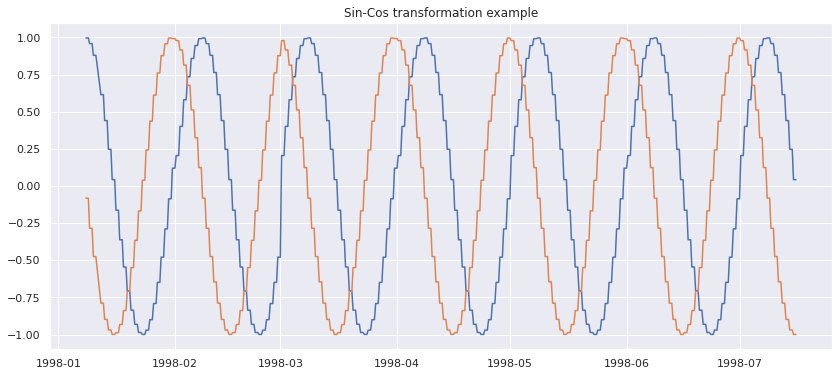

In [52]:
plt.figure(figsize=(14,6))
plt.title('Sin-Cos transformation example')
plt.plot(data_frame['day_sin'].loc[:'1998-07-15'])#.loc[:'1998-01-15']
plt.plot(data_frame['day_cos'].loc[:'1998-07-15'])#

In [53]:
a = pd.get_dummies(data_frame.index.hour.values)
a.index = data_frame.index
data_frame_dum = data_frame.join(a)

In [54]:
data_frame_dum

,T,day_sin,day_cos,month_sin,month_cos,7,15,23
date,,,,,,,,
1998-01-08 07:00:00,-22.0,0.996659,-0.081675,0.5,0.866025,1,0,0
1998-01-08 15:00:00,-25.5,0.996659,-0.081675,0.5,0.866025,0,1,0
1998-01-08 23:00:00,-29.0,0.996659,-0.081675,0.5,0.866025,0,0,1
1998-01-09 07:00:00,-36.0,0.958718,-0.284357,0.5,0.866025,1,0,0
1998-01-09 15:00:00,-35.0,0.958718,-0.284357,0.5,0.866025,0,1,0
...,...,...,...,...,...,...,...,...
2020-07-23 15:00:00,24.0,-0.999250,0.038717,-0.5,-0.866025,0,1,0
2020-07-23 23:00:00,18.0,-0.999250,0.038717,-0.5,-0.866025,0,0,1
2020-07-24 07:00:00,15.0,-0.970065,0.242844,-0.5,-0.866025,1,0,0


Дополнительно закодировали методом one-hot время снятия показаний. Теперь разделим датафрейм на матрицу признаков и меток (X и y).

In [55]:
X = data_frame_dum.drop(columns="T").to_numpy()
y = data_frame_dum["T"].to_numpy()

In [56]:
y.shape, X.shape

((24699,), (24699, 7))

In [57]:
norm = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = norm.fit_transform(y_train.reshape(-1,1))
y_train = np.squeeze(y_train)
y_test = norm.transform(y_test.reshape(-1,1))
y_test = np.squeeze(y_test)

In [58]:
from sklearn.svm import SVR
svr = SVR(C=0.01)
svr.fit(X_train, y_train)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
 print("R^2 {:.2f}".format(svr.score(X_test, y_test)))

R^2 0.82


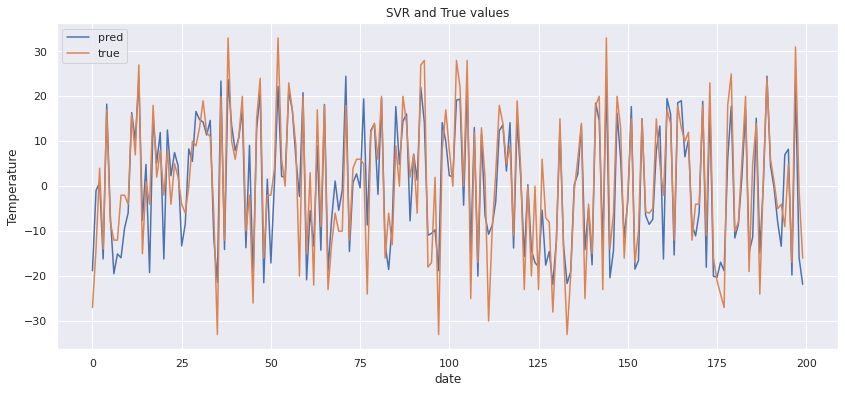

In [60]:
plt.figure(figsize=(14,6))
p = np.squeeze(norm.inverse_transform(svr.predict(X_test).reshape(-1,1)))
y_test_it = np.squeeze(norm.inverse_transform(y_test.reshape(-1,1)))
plt.plot(p[:200], label='pred')
plt.plot(y_test_it[:200], label='true')
plt.title('SVR and True values')
plt.xlabel('date')
plt.ylabel('Temperature')
plt.legend();

In [61]:
print("MAE по всем значениям {}".format(round(mean_absolute_error(p, y_test_it),3)))

MAE по всем значениям 5.22


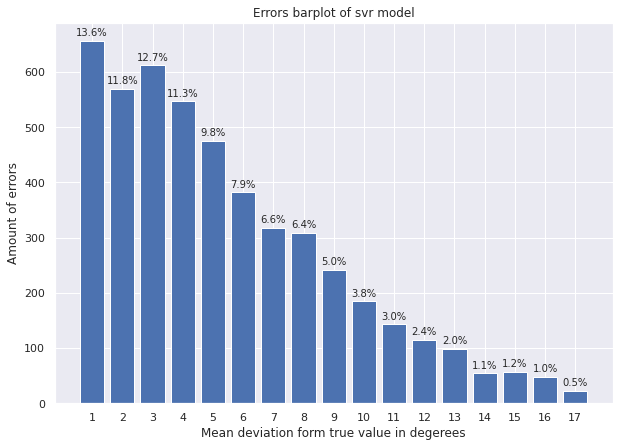

In [62]:
mean_val_svr = np.abs(p - y_test_it)
#mean_val_svr = np.abs(p - y_test_it)
diffs_svr = [np.sum(mean_val_svr<=1), np.sum((mean_val_svr<=2) & (mean_val_svr>1)),
         np.sum((mean_val_svr<=3) & (mean_val_svr>2)), np.sum((mean_val_svr<=4) & (mean_val_svr>3)),
         np.sum((mean_val_svr<=5) & (mean_val_svr>4)), np.sum((mean_val_svr<=6) & (mean_val_svr>5)),
         np.sum((mean_val_svr<=7) & (mean_val_svr>6)), np.sum((mean_val_svr<=8) & (mean_val_svr>7)),
         np.sum((mean_val_svr<=9) & (mean_val_svr>8)), np.sum((mean_val_svr<=10) & (mean_val_svr>9)),
         np.sum((mean_val_svr<=11) & (mean_val_svr>10)), np.sum((mean_val_svr<=12) & (mean_val_svr>11)),
         np.sum((mean_val_svr<=13) & (mean_val_svr>12)), np.sum((mean_val_svr<=14) & (mean_val_svr>13)),
         np.sum((mean_val_svr<=15) & (mean_val_svr>14)), np.sum((mean_val_svr<=16) & (mean_val_svr>15)),
         np.sum((mean_val_svr<=17) & (mean_val_svr>16))
        ]
def autolabel(rects, d):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        p = height/np.sum(d)
        ax.annotate('{:.1%}'.format(p),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
fig, ax = plt.subplots(figsize=(10,7))

rect = ax.bar(range(1, len(diffs_svr)+1), diffs_svr, align='center')
autolabel(rect, diffs_svr)
ax.set_xticks(range(1, len(diffs_svr)+1))
ax.set_title('Errors barplot of svr model')
ax.set_xlabel('Mean deviation form true value in degerees')
ax.set_ylabel('Amount of errors');

In [63]:
print('Меньше трех градусов {:.1%} значений'.format(np.sum(diffs_svr[:3])/np.sum(diffs_svr)))

Меньше трех градусов 38.0% значений


# Выводы
SVR модель незначительно превосходит наивную, но не лучше реккурентной. Если оценивать только по количеству ошибок в 1 градус, то она и вовсе проигрывает наивной модели. Данные для создания качественной модели должны сниматься чаще (раз в час). Так же для создания прогноза погоды используются показания давления и влажности. Источников для данных должно быть несколько. Минимально значимая выборка данных для проведения исследования на изменение климата должна составлять 30 лет, но классический интервал это 60 лет.
В этой работе узнали какой месяц самый стабильный по температуре, а так же самый теплый и холодный год, ознакомились с методами обработки данных и создания некоторых моделей.